<a href="https://colab.research.google.com/github/yootaka/AiQuest/blob/main/en4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

演習４




In [ ]:
!python --version

Python 3.6.9


In [1]:
!pip install -U torch torchvision

     |████████████████████████████████| 776.7MB 22kB/s 
     |████████████████████████████████| 12.8MB 231kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

#乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [4]:
!pip install -U -q PyDrive

In [5]:
#ライブラリの読み込み
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
#Google Cloud SDKの認証
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


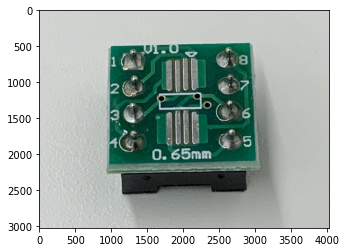

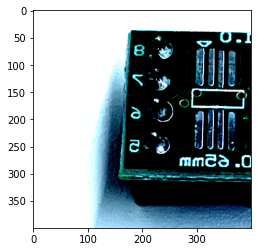

In [7]:
from google.colab import drive
drive.mount('/content/drive')

#@title デフォルトのタイトル テキスト
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './drive/My Drive/Colab Notebooks/AiQuest/en4/train/regular/regular_000.jpeg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 400
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [8]:
# train画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "./drive/My Drive/Colab Notebooks/AiQuest/en4/"
    target_path = osp.join(rootpath+phase+'/**/*.jpeg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="test")

train_list

./drive/My Drive/Colab Notebooks/AiQuest/en4/train/**/*.jpeg
./drive/My Drive/Colab Notebooks/AiQuest/en4/test/**/*.jpeg


['./drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_000.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_001.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_002.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_003.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_005.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_004.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_006.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_007.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_008.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_009.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_010.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/potato_011.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/potato/pota

In [11]:
# train画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    良品と不良品の画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[51:58]
        elif self.phase == "test":
            label = img_path[50:53]

        # ラベルを数値に変更する
        if label == "regular":
            label = 0
        elif label != "regular":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 400, 400])
1
